In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from IPython.display import Audio
import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [8]:
data_dir = '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data'

In [9]:
features = []
labels = []
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        emotion_label = folder.split('_')[-1]  # Extract the emotion label from the folder name
        
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_path.endswith('.wav'):
                # Load the audio file and extract features
                audio, sr = librosa.load(file_path, duration=3)  # Adjust the duration as needed
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)
                features.append(mfcc_mean)
                labels.append(emotion_label)

In [10]:
features = np.array(features)
labels = np.array(labels)

In [11]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [17]:
# Define the emotions and the number of samples to select from each emotion
emotions = ['angry', 'disgust', 'Fear', 'happy', 'neutral', 'Sad', 'Pleasant_surprise']
num_samples_per_emotion = 3
# Initialize empty lists for storing the selected samples
selected_samples = []

In [18]:
# Iterate through the emotions and select samples
for emotion in emotions:
    emotion_dir = os.path.join(data_dir, f'OAF_{emotion}')
    audio_files = os.listdir(emotion_dir)
    selected_files = np.random.choice(audio_files, size=num_samples_per_emotion, replace=False)
    
    for file_name in selected_files:
        file_path = os.path.join(emotion_dir, file_name)
        audio, sr = librosa.load(file_path, duration=3)
        selected_samples.append((audio, sr, emotion))

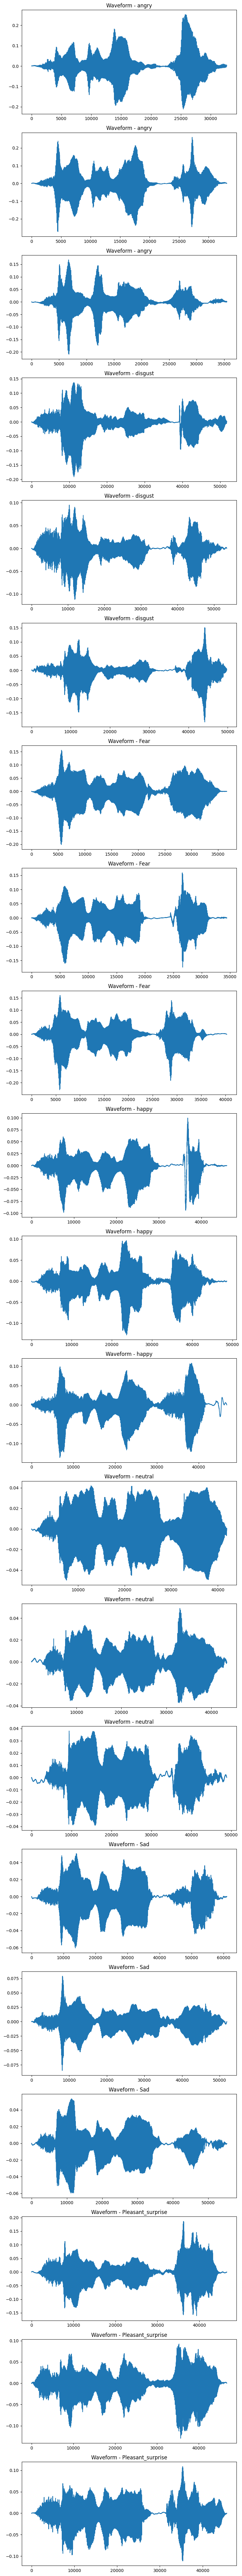

In [19]:
# Plot the selected samples
num_samples = len(selected_samples)
plt.figure(figsize=(8, 4 * num_samples))

for i, (audio, sr, emotion) in enumerate(selected_samples):
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(audio)
    plt.title(f'Waveform - {emotion}')

plt.tight_layout()
plt.show()

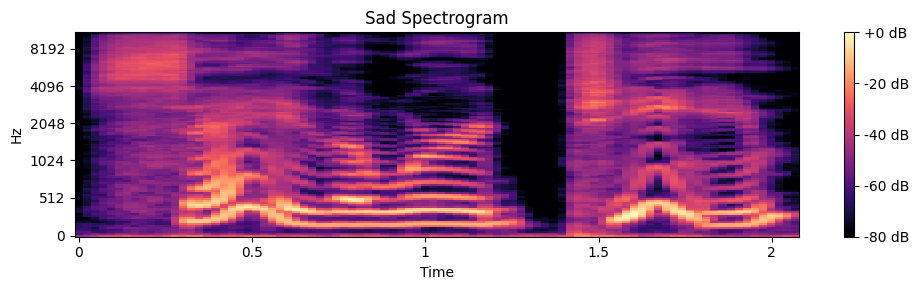

In [20]:
# Calculate the spectrogram
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)

# Convert power spectrogram to dB scale
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 3))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Sad Spectrogram')
plt.tight_layout()
plt.show()
Audio(file_path)

In [22]:
# Apply audio transformations (e.g., noise addition, time stretching, pitch shifting)
augmented_features = []
augmented_labels = []

for feature, label in zip(features, labels):
    augmented_features.append(feature)
    augmented_labels.append(label)
    
    # Apply noise addition
    noise = np.random.randn(len(feature))
    augmented_features.append(feature + 0.005 * noise)  # Adjust the noise magnitude as needed
    augmented_labels.append(label)
    
    # Apply time stretching
    augmented_features.append(librosa.effects.time_stretch(feature, rate=1.2))  # Adjust the rate as needed
    augmented_labels.append(label)
    
    # Apply pitch shifting
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# Convert the augmented lists to NumPy arrays
augmented_features = np.array(augmented_features,dtype=object)
augmented_labels = np.array(augmented_labels,dtype=object)

# Print the number of original and augmented samples
print('Original samples:', len(features))
print('Augmented samples:', len(augmented_features))

Original samples: 2800
Augmented samples: 8400


In [23]:
# Define a list to store the preprocessed data
preprocessed_data = []
file_list = os.listdir(data_dir)
# Iterate over the files
for filename in file_list:
    file_path = os.path.join(data_dir, filename)
    
    # Skip non-audio files
    if not filename.endswith('.wav'):
        continue

    # Load the audio file and obtain the waveform and sample rate
    waveform, sr = librosa.load(file_path, sr=None, dtype=np.float32)

    # Resample the audio if needed
    if sr != 22050:
        waveform = librosa.resample(waveform, sr, 22050)
        sr = 22050

In [24]:
# Encode the emotion labels
label_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
encoded_labels = np.array([label_mapping.get(label, -1) for label in labels])

# Filter out any samples with unknown emotion labels
valid_indices = np.where(encoded_labels != 1)[0]  # Get the indices from the tuple
features = features[valid_indices]
encoded_labels = encoded_labels[valid_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Reshape the input features
X_train = X_train.reshape((*X_train.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))


# Convert the emotion labels to categorical format
num_classes = len(label_mapping)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [25]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1920, 13, 1)
y_train shape: (1920, 6)
X_test shape: (480, 13, 1)
y_test shape: (480, 6)


In [26]:
#Build the cnn model architeture
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(13, 1, 1), padding='same'))

# Flatten the output
model.add(Flatten())

# Add a dense layer0
model.add(Dense(32, activation='relu'))

# Add the output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 1, 32)         320       
                                                                 
 flatten (Flatten)           (None, 416)               0         
                                                                 
 dense (Dense)               (None, 32)                13344     
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 13862 (54.15 KB)
Trainable params: 13862 (54.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/10
30/30 [==============================] - 2s 11ms/step - loss: 2.2581 - accuracy: 0.3516 - val_loss: 1.2380 - val_accuracy: 0.4771
Epoch 2/10
30/30 [==============================] - 0s 4ms/step - loss: 1.1678 - accuracy: 0.5094 - val_loss: 0.9659 - val_accuracy: 0.6313
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.9118 - accuracy: 0.6552 - val_loss: 0.7606 - val_accuracy: 0.7333
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7379 - accuracy: 0.7318 - val_loss: 0.6215 - val_accuracy: 0.8125
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.7802 - val_loss: 0.5172 - val_accuracy: 0.8375
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.5723 - accuracy: 0.7958 - val_loss: 0.4977 - val_accuracy: 0.8396
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.4987 - accuracy: 0.8224 - val_loss: 0.4269 - val_accuracy: 0.8438
Epoch 8/10
30/30 [=

In [28]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")


15/15 [==============================] - 0s 2ms/step - loss: 0.3326 - accuracy: 0.8833
Accuracy of our model on test data :  88.33333253860474 %


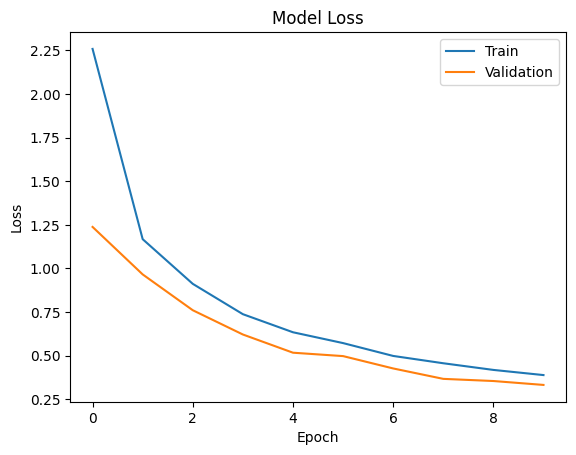

In [29]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

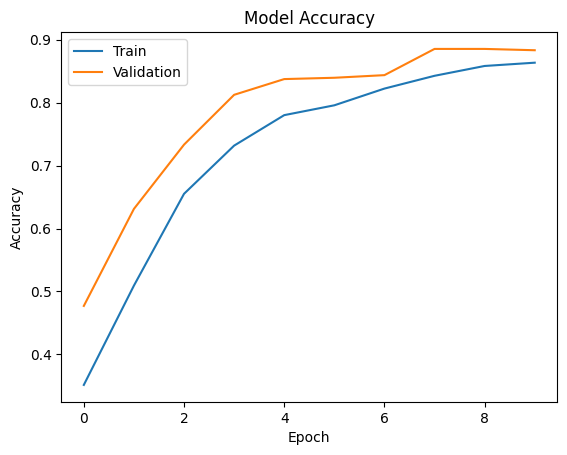

In [30]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

15/15 [==============================] - 0s 2ms/step


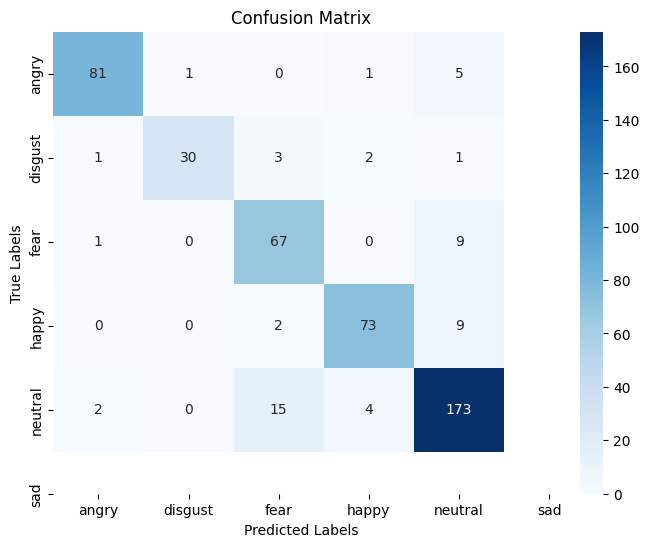

In [31]:
# Get the predicted labels for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to labels

# Convert the true labels from one-hot encoding to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']  # Replace with your actual class names
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, labels=range(len(class_names)))

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [32]:
print(report)


              precision    recall  f1-score   support

       angry       0.95      0.92      0.94        88
     disgust       0.00      0.00      0.00         0
        fear       0.97      0.81      0.88        37
       happy       0.77      0.87      0.82        77
     neutral       0.91      0.87      0.89        84
         sad       0.88      0.89      0.88       194

   micro avg       0.88      0.88      0.88       480
   macro avg       0.75      0.73      0.74       480
weighted avg       0.89      0.88      0.88       480



In [33]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=64)


Epoch 1/10
21/21 [==============================] - 0s 7ms/step - loss: 0.3729 - accuracy: 0.8661 - val_loss: 0.4027 - val_accuracy: 0.8559
Epoch 2/10
21/21 [==============================] - 0s 4ms/step - loss: 0.3648 - accuracy: 0.8661 - val_loss: 0.4232 - val_accuracy: 0.8472
Epoch 3/10
21/21 [==============================] - 0s 5ms/step - loss: 0.3607 - accuracy: 0.8638 - val_loss: 0.3749 - val_accuracy: 0.8559
Epoch 4/10
21/21 [==============================] - 0s 5ms/step - loss: 0.3501 - accuracy: 0.8705 - val_loss: 0.3631 - val_accuracy: 0.8559
Epoch 5/10
21/21 [==============================] - 0s 5ms/step - loss: 0.3885 - accuracy: 0.8452 - val_loss: 0.4393 - val_accuracy: 0.8316
Epoch 6/10
21/21 [==============================] - 0s 4ms/step - loss: 0.3587 - accuracy: 0.8676 - val_loss: 0.3505 - val_accuracy: 0.8663
Epoch 7/10
21/21 [==============================] - 0s 5ms/step - loss: 0.3348 - accuracy: 0.8676 - val_loss: 0.3420 - val_accuracy: 0.8733
Epoch 8/10
21/21 [==

In [34]:
print("Accuracy of our model on train data : " , model.evaluate(X_train,y_train)[1]*100 , "%")


60/60 [==============================] - 0s 2ms/step - loss: 0.3084 - accuracy: 0.8813
Accuracy of our model on train data :  88.12500238418579 %
